<h3>4.1 数据处理工具箱概述</h3>

<h3>4.2 utils.data简介</h3>

In [1]:
import torch
from torch.utils import data
import numpy as np

In [2]:
class TestDataset(data.Dataset):# 继承Dataset
    def __init__(self):
        self.Data=np.asarray([[1,2],[3,4],[2,1],[3,4],[4,5]])# 一些由2维向量表示的数据集
        self.Label=np.asarray([0,1,0,1,2])# 这是数据集对应的标签

    def __getitem__(self, index):
        # 把numpy转换为Tensor
        txt = torch.from_numpy(self.Data[index])
        label = torch.tensor(self.Label[index])
        return txt,label 

    def __len__(self):
        return len(self.Data)

In [3]:
Test = TestDataset()
print(Test[2])  #相当于调用__getitem__(2)
print(Test.__len__())

(tensor([2, 1], dtype=torch.int32), tensor(0, dtype=torch.int32))
5


In [4]:
test_loader = data.DataLoader(Test,batch_size=1,shuffle=False,num_workers=0)
for i,traindata in enumerate(test_loader):
    print('i:',i)
    Data,Label=traindata
    print('data:',Data)
    print('Label:',Label)


i: 0
data: tensor([[1, 2]], dtype=torch.int32)
Label: tensor([0], dtype=torch.int32)
i: 1
data: tensor([[3, 4]], dtype=torch.int32)
Label: tensor([1], dtype=torch.int32)
i: 2
data: tensor([[2, 1]], dtype=torch.int32)
Label: tensor([0], dtype=torch.int32)
i: 3
data: tensor([[3, 4]], dtype=torch.int32)
Label: tensor([1], dtype=torch.int32)
i: 4
data: tensor([[4, 5]], dtype=torch.int32)
Label: tensor([2], dtype=torch.int32)


In [5]:
dataiter=iter(test_loader)
imgs,labels=next(dataiter)
print('imgs:',imgs)
print('labels:',labels)
#imgs.size()

imgs: tensor([[1, 2]], dtype=torch.int32)
labels: tensor([0], dtype=torch.int32)


<h3>4.3 torchvision简介</h3>

4.3.1 transforms

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
transforms.Compose([
    # 将给定的 PIL.Image 进行中心切割，得到给定的 size，
    # size 可以是 tuple，(target_height, target_width)。
    # size 也可以是一个 Integer，在这种情况下，切出来的图片形状是正方形。
    transforms.CenterCrop(10),
    # 切割中心点的位置随机选取
    transforms.RandomCrop(20, padding=0),
    # 把一个取值范围是 [0, 255] 的 PIL.Image 或者 shape 为 (H, W, C) 的 numpy.ndarray，
    # 转换为形状为 (C, H, W)，取值范围是 [0, 1] 的 torch.FloatTensor
    transforms.ToTensor(),
    # 规范化到[-1,1]
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

Compose(
    CenterCrop(size=(10, 10))
    RandomCrop(size=(20, 20), padding=0)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

4.3.2 ImageFolder

tensor([1, 1, 1, 0, 0, 0, 1, 0])


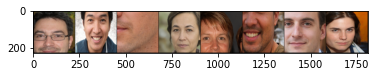

In [8]:
from torchvision import transforms, utils
from torchvision import datasets
import torch
import matplotlib.pyplot as plt 
%matplotlib inline

my_trans=transforms.Compose([
    # 随机长宽比裁剪至224
    transforms.RandomResizedCrop(224),
    # 随机水平翻转
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder('./data/', transform=my_trans)
train_loader = data.DataLoader(train_data,batch_size=8,shuffle=True,)
                                            
for i_batch, img in enumerate(train_loader):
    if i_batch == 0:
        print(img[1])
        fig = plt.figure()
        grid = utils.make_grid(img[0])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.show()
        utils.save_image(grid,'test01.png')
    break

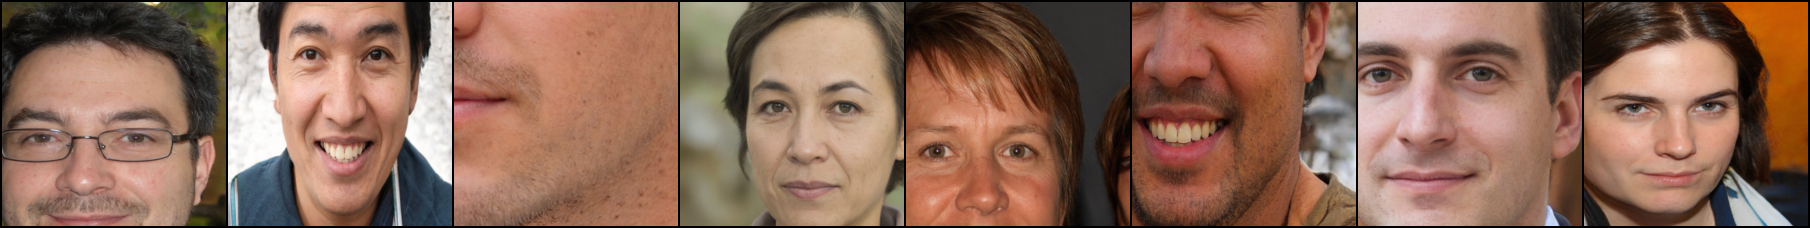

In [9]:
from PIL import Image
Image.open('test01.png')

<h3>4.4 可视化工具</h3>

4.4.2用tensorboardX可视化神经网络

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tensorboardX import SummaryWriter

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x) + F.relu(-x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [3]:
# 定义输入
input = torch.rand(32, 1, 28, 28)
# 实例化神经网络
model = Net()
# 将model保存为graph
with SummaryWriter(log_dir='logs',comment='Net') as w:
    w.add_graph(model, (input, ))

4.4.3用tensorboardX可视化损失值

In [4]:
import torch
import torch.nn as nn
from tensorboardX import SummaryWriter
import numpy as np

input_size = 1
output_size = 1
num_epoches = 60
learning_rate = 0.01

dtype = torch.FloatTensor
writer = SummaryWriter(log_dir='logs',comment='Linear')
np.random.seed(100) 
x_train = np.linspace(-1, 1, 100).reshape(100,1) 
y_train = 3*np.power(x_train, 2) +2+ 0.2*np.random.rand(x_train.size).reshape(100,1) 


model = nn.Linear(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epoches):
    inputs = torch.from_numpy(x_train).type(dtype)
    targets = torch.from_numpy(y_train).type(dtype)

    output = model(inputs)
    loss = criterion(output, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 保存loss的数据与epoch数值
    writer.add_scalar('训练损失值', loss, epoch)
